This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is meant to serve as the more interactive version of
`src.pretrain.probe_embeddings`.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import pathlib
import sys

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip

### Load data

In [3]:
dataset_cfg = imagenette.Imagenette()
# embedder_cfg = msft_beit.MsftBeitConfig(id="hf/microsoft/beit-base-patch16-384")
embedder_cfg = openai_clip.OpenaiClipConfig(id="openai/ViT-L/14@336px")

embedding_cfg = gen_embeddings.Config(
    dataset_cfg=dataset_cfg,
    embedder_cfg=embedder_cfg,
)
probe_cfg = probe_embeddings.Config(
    embedder_cfg=embedder_cfg,
    dataset_cfg=dataset_cfg,
)

DS = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
    np.float32
)
DS.xs_train.shape, DS.xs_test.shape, DS.xs_test.dtype


((9469, 768), (3925, 768), dtype('float32'))

### Dataset info

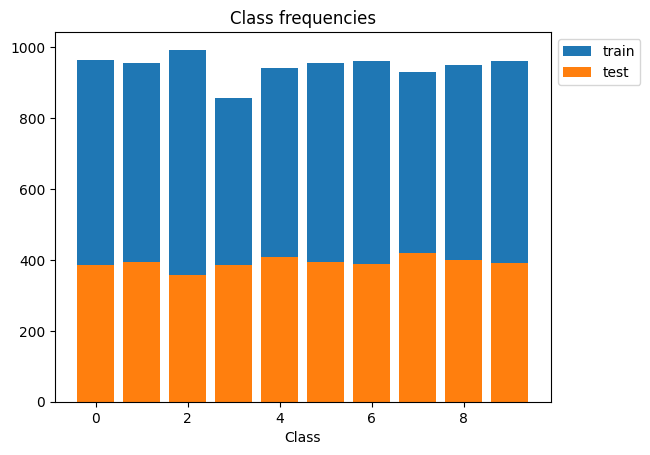

In [4]:
probe_embeddings.plot_class_frequencies(DS);

### Visualize embeddings with UMAP

In [5]:
probe_embeddings.plot_umap(DS, cfg=probe_cfg).show()

### Visualize suspicious dataset examples

In [6]:
# Compute test examples that are classified wrong according to 10-NN.
clf = cuml.neighbors.kneighbors_classifier.KNeighborsClassifier(
    n_neighbors=3,
    weights="uniform",
    metric="euclidean",
)
clf.fit(DS.xs_train, DS.ys_train)
preds = clf.predict(DS.xs_test)

err_idxs = np.where(preds != DS.ys_test)[0]
err_idxs

array([ 784,  956, 1375, 1705, 1843, 2213, 2258, 3080, 3187, 3546])

Found cached dataset imagenette (/run/user/61805/huggingface/datasets/frgfm___imagenette/320px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


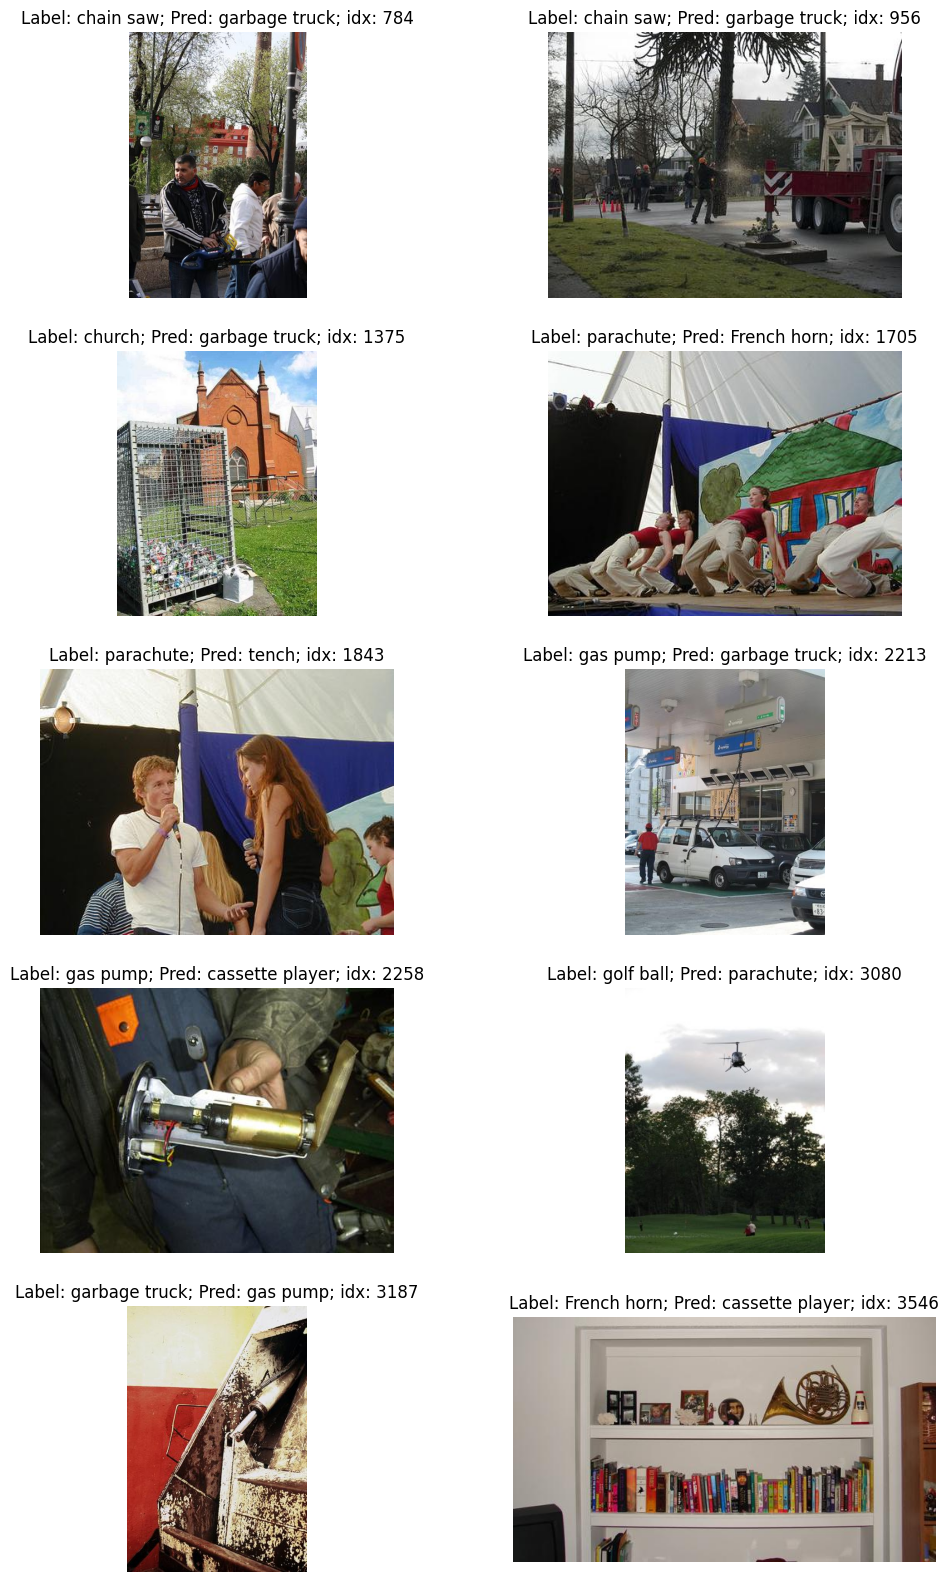

In [8]:
ds_orig_test = dataset_cfg.get_test_ds()
sus_idxs = [71, 82, 426, 956, 2095, 2482]

n_rows = 5
n_cols = 2
plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, idx in enumerate(err_idxs):

    idx = int(idx)
    img = ds_orig_test[idx]["image"]

    label_num = ds_orig_test[idx]["label"]
    label_str = dataset_cfg.class_names[label_num]

    pred_num = preds[idx]
    pred_str = dataset_cfg.class_names[pred_num]

    # Plot image without axes
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label: {label_str}; Pred: {pred_str}; idx: {idx}")

### Visualize embeddings with PCA

In [9]:
probe_embeddings.plot_pca(DS, cfg=probe_cfg).show()

/run/user/61805/conda-envs/scaling-v2.1/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### Measure scaling laws

In [10]:
df = probe_embeddings.get_scaling_results(
    ds=DS,
    cfg=dataclasses.replace(probe_cfg, report_per_class_results=True),
)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:17: RuntimeWarning:

divide by zero encountered in log

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:18: RuntimeWarning:

divide by zero encountered in log

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:21: RuntimeWarning:

invalid value encountered in multiply



[W] [21:32:10.533360] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:23.967618] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:26.009704] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:33.418437] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:35.171314] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:36.787313] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:36.980043] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:38.415633] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:40.192237] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:44.384955] L-BFGS stopped, because the line search fa

/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:28: RuntimeWarning:

divide by zero encountered in log



[W] [21:32:48.248814] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:48.548230] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:48.717791] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:50.051161] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:50.890115] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:52.917180] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:53.956684] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:54.431934] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:56.172348] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:32:58.487979] L-BFGS stopped, because the line search fa

### Plot scaling laws

In [11]:
def super_fancy_detailed_plot(
    probe: str,
    per_class: bool = False,
    cls_start: int = 0,
    cls_end: int = 10,
    breakdown_by_class: bool = False,
    min_err=1e-6,
    **px_kwargs,
):
    filt_str = "&".join(
        [
            f"probe == '{probe}'",
            f"per_class == {per_class}",
            f"cls_start == {cls_start}",
            f"cls_end == {cls_end}",
        ]
    )
    cdf = df.query(f"{filt_str}").copy().sort_values(["n_train"])
    cdf["target_cls"] = "all"

    if breakdown_by_class:
        sub_dfs = []
        for cls in range(cls_start, cls_end):
            sub_df = cdf.copy()
            sub_df.err = 1 - sub_df[f"acc_{cls}"]
            sub_df.loc[sub_df.err == 0, "err"] = min_err / 10
            sub_df.target_cls = dataset_cfg.class_names[cls]
            sub_dfs.append(sub_df)
        cdf = pd.concat(sub_dfs)

    fig = px.line(
        cdf,
        x="n_train",
        y="err",
        color="target_cls",
        facet_col={"knn": "k", "linear": "c"}[probe],
        **px_kwargs,
    )

    # Draw horizontal line for min nonzero error, behind all other lines
    # Make color black
    # Do it on all facets
    fig.add_scatter(
        x=[1, cdf.n_train.max()],
        y=[min_err, min_err],
        name="1 / max_n_train",
        line_dash="dash",
        line_color="black",
        row="all",
        col="all",
    )

    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")

    fig.update_traces(marker=dict(size=10))
    fig.update_layout(legend=dict(itemsizing="constant"))

    fig.show()


In [12]:
super_fancy_detailed_plot(
    probe="knn",
    per_class=True,
    breakdown_by_class=True,
    width=900,
    height=400,
    min_err=1e-3
)

super_fancy_detailed_plot(
    probe="knn",
    per_class=True,
    breakdown_by_class=True,
    width=900,
    height=400,
    min_err=1e-3
)


In [ ]:
tot_classes = DS.n_classes
for n_classes in probe_cfg.n_classes:
    for i in range(probe_cfg.mx_cont_rngs):
        for per_class in [False, True]:
            cls_start = i * n_classes
            cls_end = cls_start + n_classes
            if cls_end > tot_classes:
                break

            fig = probe_embeddings.plot_scaling_results(
                df=df,
                n_classes=n_classes,
                cls_start=cls_start,
                cls_end=cls_end,
                per_class=per_class,
            )
            fig.show()

            break
        break
    break